In [247]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F


from chmp.ds import Loop, define, mpl_set
from ipytest import magics
from tqdm import tqdm

In [258]:
__file__ = 'TimeSeries.ipynb'
floatx = torch.float32

# Pytorch API Tests

In [284]:
%%run_pytest[clean]

def test_distributions_sample_api():
    p = dist.Normal(torch.zeros(3, dtype=floatx), torch.ones(3, dtype=floatx))
    
    assert p.sample().shape == (3,)
    assert p.sample((2,)).shape == (2, 3)
    assert p.sample((1, 2)).shape == (1, 2, 3)
    
    with pytest.raises(TypeError):
        p.sample(2)
        
    # can only use tuple arguments
    with pytest.raises(TypeError):
        assert p.sample([2]).shape == (2, 3)
        
        
def test_module_multiple_inputs():
    class CustomModule(nn.Module):
        def forward(self, a, b):
            return (a * b).sum()
    
    mod = CustomModule()
    a = torch.tensor([1.0, 2.0], requires_grad=True)
    b = torch.tensor([3.0, 4.0], requires_grad=True)
    
    c = mod(a, b)
    c.backward()
    
    assert a.grad.detach().numpy() == pytest.approx([3.0, 4.0])
    assert b.grad.detach().numpy() == pytest.approx([1.0, 2.0])

================================================================================ test session starts ================================================================================
platform darwin -- Python 3.6.4, pytest-3.3.2, py-1.5.2, pluggy-0.6.0
rootdir: /Volumes/Home/Code/misc-exp, inifile: pytest.ini
collected 2 items

TimeSeries.py ..                                                                                                                                                              [100%]

============================================================================= 2 passed in 0.07 seconds ==============================================================================


In [477]:
import bisect

In [563]:
class PiecewiseSchedule:
    def __init__(self, schedule):
        if schedule  and schedule[0][0] is None:
            _, self.left = schedule[0]
            schedule = schedule[1:]
            
        else:
            _, self.left = schedule[0]
            
        if schedule and schedule[-1][0] is None:
            _, self.right = schedule[-1]
            schedule = schedule[:-1]
        
        else:
            _, self.right = schedule[-1]
        
        self.x = [x for x, _ in schedule]
        self.y = [y for _, y in schedule]

    def __call__(self, x):
        if x < self.x[0]:
            return self.left
        
        elif x >= self.x[-1]:
            return self.right
        
        else:
            interval = bisect.bisect_left(self.x[1:-1], x)
            u = (x - self.x[interval]) / (self.x[interval + 1] - self.x[interval])
            return self.interpolate(u, self.y[interval], self.y[interval + 1])
        
        raise RuntimeError()
    
    def interpolate(self, u, x0, x1):
        raise NotImplementedError()
    
        
class PiecewiseLinearSchedule(PiecewiseSchedule):
    @staticmethod
    def interpolate(u, x0, x1):
        return (1 - u) * x0 + u * x1
    
    
class PiecewiseLogSchedule(PiecewiseSchedule):
    @staticmethod
    def interpolate(u, x0, x1):
        return (x0 ** (1 - u)) * (x1 ** u)

In [685]:
%%run_pytest[clean] -l

def test_piecewise_linear_schedule():
    schedule = PiecewiseLinearSchedule([
        (None, 20),
        (10, 30),
        (20, 40),
        (None, 50),
    ])
    
    assert schedule(5.0) == pytest.approx(20.0)
    assert schedule(10.0) == pytest.approx(30.0)
    assert schedule(12.5) == pytest.approx(32.5)
    assert schedule(15.0) == pytest.approx(35.0)
    assert schedule(17.5) == pytest.approx(37.5)
    assert schedule(20.0) == pytest.approx(50.0)
    assert schedule(25.0) == pytest.approx(50.0)
    
    
def test_piecewise_linear_schedule_no_boundaries():
    schedule = PiecewiseLinearSchedule([
        (10, 30),
        (20, 40),
    ])
    
    assert schedule(5) == pytest.approx(30)
    assert schedule(10) == pytest.approx(30)
    assert schedule(12.5) == pytest.approx(32.5)
    assert schedule(15.0) == pytest.approx(35.0)
    assert schedule(17.5) == pytest.approx(37.5)
    assert schedule(20) == pytest.approx(40)
    assert schedule(25) == pytest.approx(40)
    

================================================================================ test session starts ================================================================================
platform darwin -- Python 3.6.4, pytest-3.3.2, py-1.5.2, pluggy-0.6.0
rootdir: /Volumes/Home/Code/misc-exp, inifile: pytest.ini
collected 2 items

TimeSeries.py ..                                                                                                                                                              [100%]

============================================================================= 2 passed in 0.07 seconds ==============================================================================


# Support Code


In [895]:
def safe_scale(x):
    return 1e-2 + F.softplus(x)


class SafeScale(nn.Module):
    def forward(x):
        return safe_scale(x)
    
    
class Cat(nn.Module):
    def __init__(self, dim, nargs=None):
        super().__init__()
        self.dim = dim
        self.nargs = nargs
    
    def forward(self, *args):
        if self.nargs is None:
            self.nargs = len(args)
        
        assert self.nargs == len(nargs)
        return torch.cat(list(args), dim)

class Parallel(nn.Module):
    def __init__(self, *modules):
        super().__init__()
        self.modules = modules
    
    def forward(self, x):
        return tuple(mod(x) for x in self.modules)
    
    
class MultiLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.out_features = out_features
        if not isinstance(in_features, (tuple, list)):
            self.in_features = (in_features,)
        
        else:
            self.in_features = tuple(in_features)
    
        self.layer = nn.Linear(sum(self.in_features), self.out_features)
    
    @property
    def bias(self):
        return self.layer.bias

    @property
    def weight(self):
        return self.layer.weight
    
    def forward(self, *x):
        # allow MultiLinear to be used in a Sequential Container
        if len(x) == 1 and len(self.in_features) != 1:
            assert isinstance(x[0], tuple)
            x = x[0]
        
        assert len(x) == len(self.in_features)
        x = torch.cat(list(x), dim=-1)
        return self.layer(x)
    
    
class LocationScaleNetwork(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        
        self.to_hidden = MultiLinear(n_input, n_hidden)
        self.to_loc = nn.Linear(n_hidden, n_output)
        self.to_scale = nn.Linear(n_hidden, n_output)
        
        nn.init.kaiming_normal_(self.to_hidden.layer.weight)
        nn.init.constant_(self.to_hidden.layer.bias, 0.0)
        
        nn.init.xavier_uniform_(self.to_loc.weight)
        nn.init.constant_(self.to_loc.bias, 0.0)
        
        nn.init.kaiming_normal_(self.to_scale.weight)
        nn.init.constant_(self.to_scale.bias, 0.0)
        
    def forward(self, *x):
        x = F.elu(self.to_hidden(*x))
        return self.to_loc(x), safe_scale(self.to_scale(x))

# "Bouncing Ball" Example

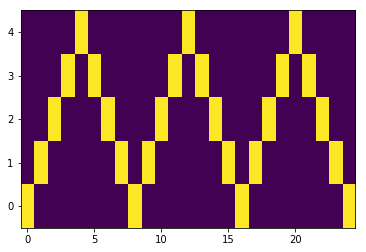

In [1489]:
# Create default graph
x = np.zeros((25, 10, 5))

idx = np.arange(10)
pos = np.random.randint(0, 5, size=10)
vel = np.ones(10, dtype=np.int64)
for t in range(0, x.shape[0]):
    x[t, idx, pos] = 1
    pos += vel
    
    sel = np.logical_or((pos <= 0), (pos >= x.shape[-1] - 1))
    vel[sel] = -vel[sel]
    pos = np.clip(pos, 0, x.shape[-1] - 1)
        
plt.imshow(x[:, 0, :].T, interpolation='none', origin='lower', aspect='auto')

In [1490]:
x = torch.from_numpy(x.astype('float32'))

## Variational Autoencoder

Generative model:

$$
\begin{align}
    z &\sim \mathcal{N}(0, 1) \\
    x &\sim \mathcal{N}(\mu_p(x), \sigma_p(x))
\end{align}
$$

Variational model:

$$
    z \sim \mathcal{N}(\mu_q(x), \sigma_q(x))
$$

In [695]:
def multi_append(lists, *items):
    for l, i in zip(lists, items):
        l.append(i)

In [985]:
class IndependentEncoder(nn.Module):
    def __init__(self, dim_x, n_hidden, dim_z):
        super().__init__()
        self.qz_network = LocationScaleNetwork(dim_x, n_hidden, dim_z)
    
    def __call__(self, x):
        qz_loc, qz_scale = self.qz_network(x)
        qz = dist.Normal(qz_loc, qz_scale)
        return qz, qz.rsample()
    
        #res = [], [], []
        #
        #for t in range(len(x)):        
        #    qz_loc, qz_scale = self.qz_network(x[t])
        #    eps = torch.normal(torch.zeros_like(qz_loc), torch.ones_like(qz_scale))
        #    
        #    multi_append(res, qz_loc, qz_scale, qz_loc + eps * qz_scale)
        #
        #return (
        #    dist.Normal(torch.stack(res[0]), torch.stack(res[1])),
        #    torch.stack(res[2]),
        #)

    
class IndependentDecoder(nn.Module):
    def __init__(self, dim_x, n_hidden, dim_z):
        super().__init__()
        self.px_network = LocationScaleNetwork(dim_z, n_hidden, dim_x)
    
    def __call__(self, z):
        px_loc, px_scale = self.px_network(z)
        return dist.Normal(px_loc, px_scale)
        

class IndependentDecoderLoop(nn.Module):
    def __init__(self, dim_x, n_hidden, dim_z):
        super().__init__()
        self.px_network = LocationScaleNetwork(dim_z, n_hidden, dim_x)
    
    def __call__(self, z):
        res = [], []
        
        for t in range(len(z)):
            px_loc, px_scale = self.px_network(z[t])
            multi_append(res, px_loc, px_scale)
        
        return dist.Normal(torch.stack(res[0]), torch.stack(res[1]))
    
    
class StandardNormalPrior(nn.Module):
    def __call__(self, x, z):
        return dist.Normal(0, 1)
    
    
class DeepKalmanFilter(nn.Module):
    def __init__(self, *, encoder, decoder, prior):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        
    def compute_loss(self, x, regularization=1.0):
        qz, z = self.encoder(x)
        px = self.decoder(z)
        pz = self.prior(x, z)
        
        elbo = (
            px.log_prob(x).sum() 
            - regularization * dist.kl.kl_divergence(qz, pz).sum()
        )
        
        return -elbo / (x.shape[0] * x.shape[1])
    
    def compute_reconstruction_error(self, x):
        _, z = self.encoder(x)
        x_mean = self.decoder(z).mean
        return float(((x - x_mean) ** 2.0).mean())        

In [974]:
regularization_schedule = PiecewiseLinearSchedule([
    (0, 1e-2), 
    (15_000, 1e-2),
    (20_000, 1e-0),
])

n_hidden = 30
dim_x = 5
dim_z = 2
    
results = []
for loop, _ in Loop.over(range(10)):
    model = DeepKalmanFilter(
        encoder=IndependentEncoder(dim_x, n_hidden, dim_z),
        decoder=IndependentDecoder(dim_x, n_hidden, dim_z),
        prior=StandardNormalPrior(),
    )
    model.train(True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
    losses = []

    for idx in loop.nest(range(40_000)):
        optimizer.zero_grad()
        loss = model.compute_loss(
            x, regularization=regularization_schedule(idx),
        )
        loss.backward()
        optimizer.step()

        if (idx % 50) == 0:
            reconst_error = model.compute_reconstruction_error(x)
            losses += [(float(loss), reconst_error)]
            loop.print(f"{loop} {idx}: {loss:.3f} {reconst_error:.3f}")
    
    results += [np.asarray(losses)]
    
results = np.asarray(results)
losses = np.asarray(losses)

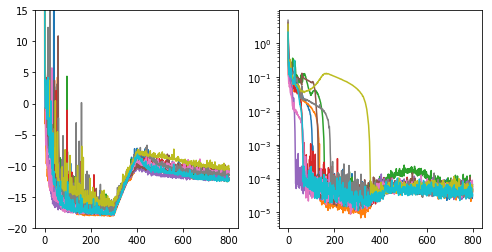

In [958]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax1)
plt.plot(results[..., 0].T)
plt.ylim(-20, +15)

plt.sca(ax2)
plt.plot(results[..., 1].T)
plt.yscale('log')
pass

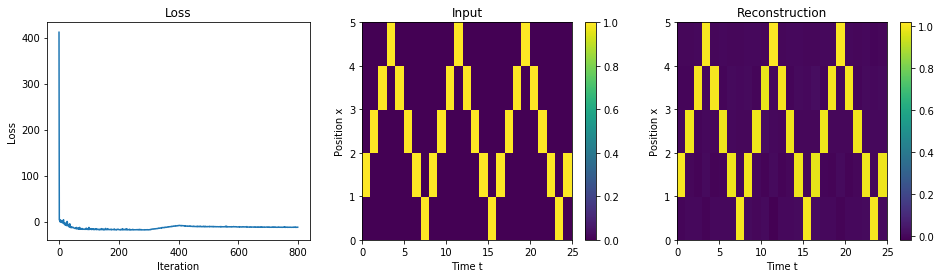

In [964]:
_, z = model.encoder(x)
res = model.decoder(z).mean.detach().numpy()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

plt.sca(ax1)
plt.plot(losses[..., 0])
mpl_set(title='Loss', xlabel='Iteration', ylabel='Loss')

plt.sca(ax2)
plt.pcolormesh(np.asarray(x[:, 0, :]).T)
mpl_set(colorbar=True, title='Input', xlabel='Time t', ylabel='Position x')

plt.sca(ax3)
plt.pcolormesh(res[:, 0, :].T)
mpl_set(colorbar=True, title='Reconstruction', xlabel='Time t', ylabel='Position x')

In [960]:
x_ = x.detach().numpy()
z_ = np.asarray([i.detach().numpy() for i in z])

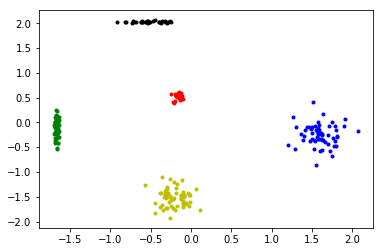

In [961]:
for i, c in enumerate('rgbyk'):
    plt.plot(
        z_[..., 0][x_[..., i] == 1].flatten(),
        z_[..., 1][x_[..., i] == 1].flatten(),
        c + '.'
    )

## Deep Kalman Filter

Modeled after [Deep Kalman Filters (2015)](https://arxiv.org/abs/1511.05121).

$$
\begin{align}
    z_1 &\sim \mathcal{N}(\mu_{pz,0}, \sigma_{pz,0}) \\
    z_t &\sim \mathcal{N}(\mu_{pz}(z_{t- 1}), \sigma_{pz}(z_{t - 1})) \\
    x_t &\sim \mathcal{N}(\mu_{px}(z_t)), \sigma_{px}(z_t))
\end{align}
$$

Posterior factorization:
$$
    p(z_t|\{x\}) = p(z_t | z_{t - 1}, x_{t:T})
$$

Variational approximation:
$$
\begin{align}
    z_1 &\sim \mathcal{N}(\mu_{qz,0}(x_{t:T}), \sigma_{qz,0}( x_{1:T})) \\
    z_t &\sim \mathcal{N}(\mu_{qz}(z_{t - 1}, x_{t:T}), \sigma_{qz}(z_{t - 1}, x_{t:T}))
\end{align}
$$

Use an RNN to capture the dependence on $x_{t:T}$.

In [1048]:
class RecurrentPrior(nn.Module):
    def __init__(self, dim_z, n_hidden):
        super().__init__()
        self.initial_loc = nn.Parameter(
            torch.zeros(dim_z, dtype=torch.float32, requires_grad=True)
        )
        self.initial_scale_raw = nn.Parameter(
            torch.zeros(dim_z, dtype=torch.float32, requires_grad=True)
        )
        
        self.pz_network = LocationScaleNetwork(dim_z, n_hidden, dim_z)
    
    def __call__(self, x, z):
        batch_size = x.shape[1]
        pz0_loc = self.initial_loc
        pz0_scale = safe_scale(self.initial_scale_raw)
        
        pz_loc, pz_scale = self.pz_network(z[:-1, ...])
        
        pz_loc = torch.cat([
            pz0_loc.expand(1, 1, -1).repeat(1, batch_size, 1),
            pz_loc,
        ], dim=0)
        pz_scale = torch.cat([
            pz0_scale.expand(1, 1, -1).repeat(1, batch_size, 1),
            pz_scale,
        ], dim=0)
        
        return dist.Normal(pz_loc, pz_scale)
    
    def simulate(self, time_steps, batch_size=1):
        z = [
            self.get_initial_dist().sample((batch_size,))
        ]
        
        for _ in range(time_steps - 1):
            pz_loc, pz_scale = self.pz_network(z[-1])
            pz = dist.Normal(pz_loc, pz_scale)
            z += [pz.sample()]
        
        return torch.stack(z)
        
    def get_initial_dist(self):
        pz0_loc = self.initial_loc
        pz0_scale = safe_scale(self.initial_scale_raw)
        return dist.Normal(pz0_loc, pz0_scale)

In [1073]:
class RecurrentEncoder(nn.Module):
    def __init__(self, dim_x, n_hidden, dim_z):
        super().__init__()
        self.summarize_x = nn.GRU(
            input_size=dim_x,
            hidden_size=n_hidden,
        )
        
        self.qz0_network = LocationScaleNetwork(n_hidden, n_hidden, dim_z)
        self.qz_network = LocationScaleNetwork((dim_z, n_hidden), n_hidden, dim_z)
        
    def __call__(self, x):
        backward_x = x[torch.arange(len(x) - 1, -1, -1).long(), ...]
        x_summary_backward, _ = self.summarize_x(backward_x)
        x_summary_backward = F.relu(x_summary_backward)
        
        res = [], [], []
        
        qz0_loc, qz0_scale = self.qz0_network(x_summary_backward[-1])
        z0 = dist.Normal(qz0_loc, qz0_scale).rsample()
        
        multi_append(res, qz0_loc, qz0_scale, z0)
        
        for t in range(1, len(x)):
            z_arg = res[2][t - 1]
            x_arg = x_summary_backward[len(x) - 1 - t]
            
            qz_loc, qz_scale = self.qz_network(z_arg, x_arg)
            z = dist.Normal(qz_loc, qz_scale).rsample()
            
            multi_append(res, qz_loc, qz_scale, z)
        
        qz_loc = torch.stack(res[0])
        qz_scale = torch.stack(res[1])
        z = torch.stack(res[2])
        
        return dist.Normal(qz_loc, qz_scale), z

In [1075]:
regularization_schedule = PiecewiseLinearSchedule([
    (0, 1e-2), 
    (15_000, 1e-2),
    (20_000, 1e-0),
])

n_hidden = 30
dim_x = 5
dim_z = 2
    
results = []
for loop, _ in Loop.over(range(1)):
    model = DeepKalmanFilter(
        #encoder=IndependentEncoder(dim_x, n_hidden, dim_z),
        encoder=RecurrentEncoder(dim_x, n_hidden, dim_z),
        decoder=IndependentDecoder(dim_x, n_hidden, dim_z),
        prior=RecurrentPrior(dim_z, n_hidden),
    )
    model.train(True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
    losses = []

    for idx in loop.nest(range(500_000)):
        optimizer.zero_grad()
        loss = model.compute_loss(
            x, regularization=regularization_schedule(idx),
        )
        loss.backward()
        optimizer.step()

        if (idx % 100) == 0:
            reconst_error = model.compute_reconstruction_error(x)
            losses += [(float(loss), reconst_error)]
            loop.print(f"{loop} {idx}: {loss:.3f} {reconst_error:.3f}")
    
    results += [np.asarray(losses)]
    
results = np.asarray(results)
losses = np.asarray(losses)

KeyboardInterrupt: 

(-20, 10)

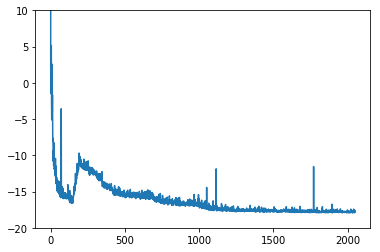

In [1078]:
plt.plot(losses[:, 0])
plt.ylim(-20, 10)

In [1097]:
sim_z = model.prior.simulate(time_steps=20, batch_size=10)
sim_x = model.decoder(sim_z).sample()
sim_x = sim_x.detach().numpy()

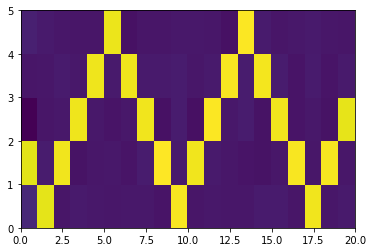

In [1109]:
plt.pcolormesh(sim_x[:, 9, :].T)